In [9]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification

In [10]:
#Using Google Colab free GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
#!pip install transformers

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
def load_FinnSentiment_data():
    """
    Load sentences and labels from FinnSentiment data set.
    """
    df = pd.read_csv('/content/drive/My Drive/FinBERT-training/FinnSentiment2020.tsv', sep='\t', header=None, quoting=csv.QUOTE_NONE)
    df = df.rename(columns={10: "sentence", 3: "label"})

    #change labels to negative = 0, neutral = 1, positive = 2
    df['label'] += 1

    sentences = df['sentence'].tolist()
    labels = df['label'].tolist()

    print('number of sentences:', len(sentences))
    print('number of labels:', len(labels))
    return sentences, labels

In [12]:
def plot_classification_results(y_test, y_pred):
    """
    Plot test set results
    The values in the arrays are 0=negative, 1=neutral and 2=positive
    """
    ax = sns.countplot(x=y_test, hue=y_pred);
    ax.set_xticklabels(['negative', 'neutral', 'positive'])
    ax.set_xlabel('actual class', fontweight='bold')
    ax.legend(['negative', 'neutral', 'positive'], title='predicted class')

In [17]:
sentences, labels = load_FinnSentiment_data()

#lowercase sentences
sentences = [sentence.lower() for sentence in sentences]

#split data to training set and test set
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.20, 
                                                                              shuffle=True, random_state=1)

#split training set to training set and validation set
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels,
                                                                            test_size=1/8, shuffle=False)

print("number of training samples:", len(train_sentences))
print("number of validation samples:", len(val_sentences))
print("number of test samples:", len(test_sentences))

number of sentences: 27000
number of labels: 27000
number of training samples: 18900
number of validation samples: 2700
number of test samples: 5400


In [18]:
model = TFBertForSequenceClassification.from_pretrained('TurkuNLP/bert-base-finnish-uncased-v1', num_labels=3)
tokenizer = BertTokenizer.from_pretrained("TurkuNLP/bert-base-finnish-uncased-v1")

train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=39)
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=39)
test_encodings = tokenizer(test_sentences, truncation=True, padding=True, max_length=39)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices(
    dict(test_encodings)
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')
model.fit(train_dataset.batch(16), validation_data=val_dataset.batch(16), batch_size=16, epochs=10, callbacks=[early_stopping])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
1182/1182 [==============================] - 202s 160ms/step - loss: 0.4440 - accuracy: 0.8279 - val_loss: 0.3584 - val_accuracy: 0.8500
Epoch 2/10
1182/1182 [==============================] - 193s 163ms/step - loss: 0.2428 - accuracy: 0.9107 - val_loss: 0.4094 - val_accuracy: 0.8452


              precision    recall  f1-score   support

           0       0.64      0.69      0.66       819
           1       0.92      0.88      0.90      3963
           2       0.73      0.86      0.79       618

    accuracy                           0.85      5400
   macro avg       0.76      0.81      0.78      5400
weighted avg       0.85      0.85      0.85      5400



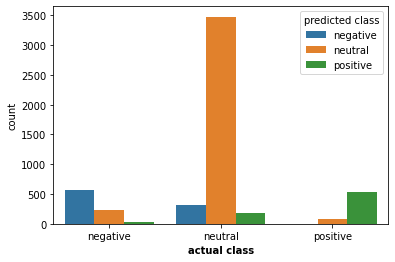

In [19]:
#make test set predictions
output = model.predict(test_dataset.batch(16))
y_pred = output['logits']

#choose the class with the highest probability to be the prediction
y_pred = tf.math.argmax(y_pred, axis=1)
y_pred = np.array(y_pred)

print(classification_report(test_labels, y_pred))
plot_classification_results(test_labels, y_pred)

In [20]:
print("y_pred shape:", y_pred.shape)

np.save('/content/drive/My Drive/FinBERT-training/FinBERT-test-predictions.npy', y_pred)

y_pred shape: (5400,)
